In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
import missingno as msno


# 1 предобработка данных 
- проверить наличие пустых значений
- понять чем заполнить(среднее, нули)
- преобразовать стринговые переменные в dummy при необходимости


# 2 построение моделей
- оптимизируемся на разные метрики
- разные типы кросс-валидации
- разная предобработка категориальных признаков 
- разный тип перебора гиперпараметров
- отбор признаков
- KNN, лин. модели, лин с регуляризацией, ансамбли (случайный лес, 3 вида бустингов(от 3 разных компаний))

# 3 интерпретация результатов
- выбор лучшей модели исходя из того как они ведут себя на тестовой выборке (precision, recall, f1 , ROC_AUC, accuracy)

In [3]:
def add_qual_line(model,data):
    model_name = model.best_params_
    model_accuracy = accuracy_score(y_holdout, model.predict(X_holdout))
    model_recall = recall_score(y_holdout, model.predict(X_holdout))

    predict_qual = {'accuracy': model_accuracy,
                    'recall': model_recall,
                    'model': model_name}
    data = data.append(predict_qual, ignore_index=True)
    return data

In [4]:
data_raw = pd.read_csv('https://raw.githubusercontent.com/rebeccabilbro/titanic/master/data/train.csv')
#выбросим лишнее
data_raw.drop(['Cabin','Ticket','Name', 'PassengerId' ], axis=1, inplace=True)

In [5]:
data_raw

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [6]:
#проверим пропуски
{key:data_raw[key].isna().sum() for key in data_raw.columns}

{'Survived': 0,
 'Pclass': 0,
 'Sex': 0,
 'Age': 177,
 'SibSp': 0,
 'Parch': 0,
 'Fare': 0,
 'Embarked': 2}

<AxesSubplot:>

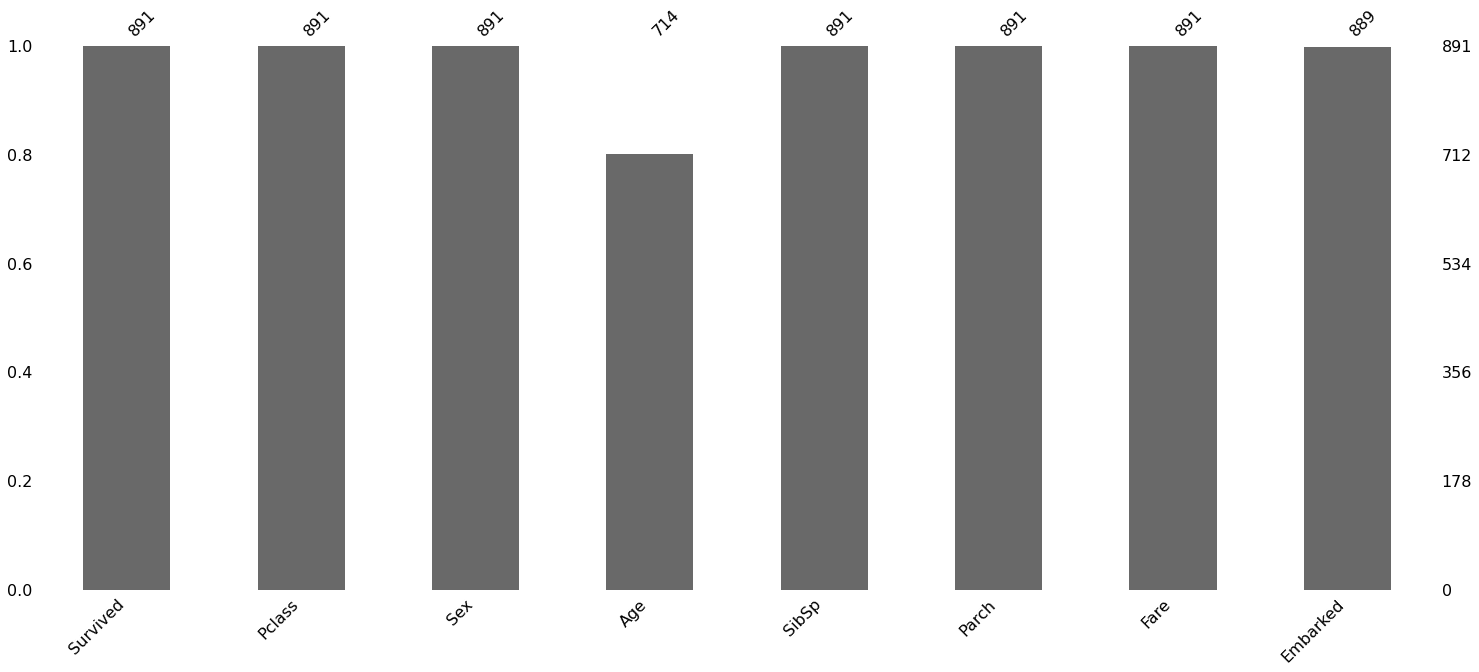

In [7]:
msno.bar(data_raw)

<AxesSubplot:>

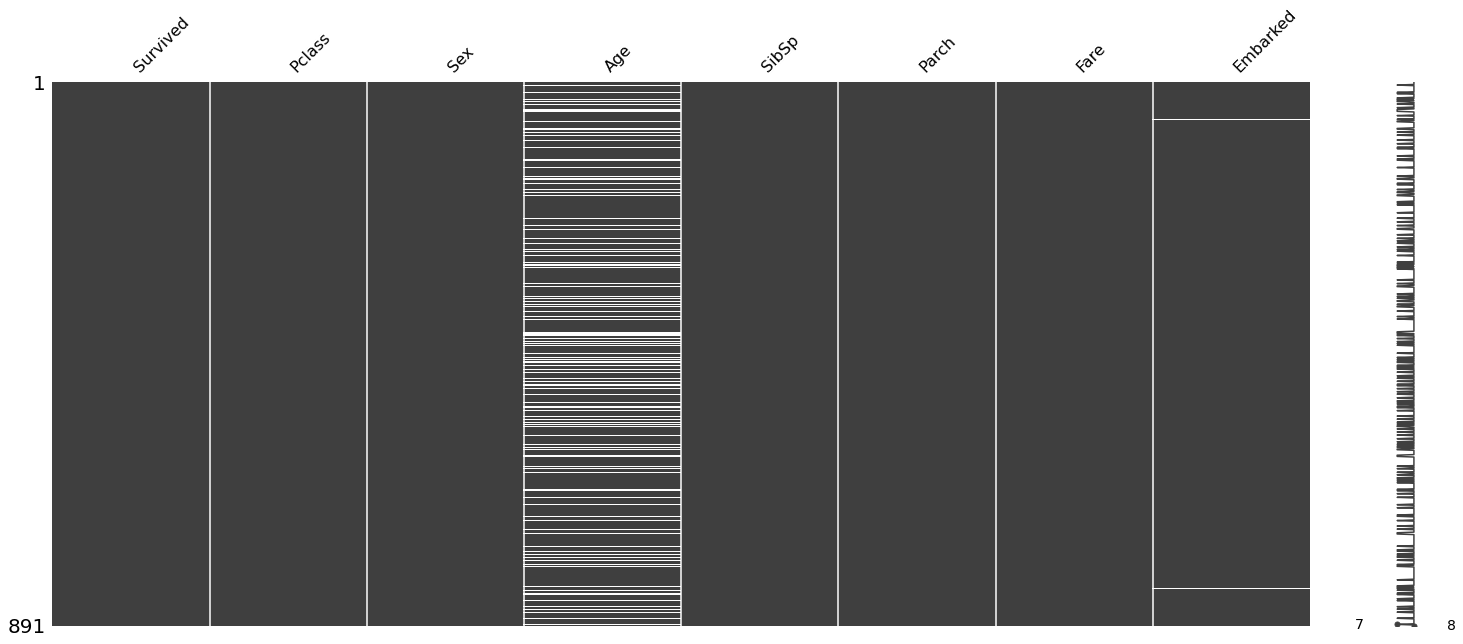

In [8]:
msno.matrix(data_raw)

In [9]:
data = data_raw.copy()


median_age = data['Age'].median()
data['Age'].fillna(median_age, inplace=True) 
data['Embarked'].fillna(data['Embarked'].value_counts().index[0], inplace=True) #заменим пропуски последующим значением 

y = data['Survived']
X = data.drop(['Survived'], axis=1)


Выделим 70% выборки (X_train, y_train) под обучение и 30% в качестве отложенной выборки (X_holdout, y_holdout). Отложенная выборка никак не будет участвовать в настройке параметров моделей, на ней мы в конце, после этой настройки, оценим качество полученной модели.



In [10]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,
                                                          random_state=17)

In [11]:
#one-hot encoding для пола
feature_categorical = ["Sex","Embarked", 'Pclass']
feature_categoricals = ['Parch','SibSp']#категориальные, с более чем 2 категориями
X_train_prep = pd.get_dummies(X_train, columns=feature_categorical, drop_first=True)
X_holdout_prep = pd.get_dummies(X_holdout, columns=feature_categorical, drop_first=True)


In [12]:
X_train_prep

,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
66,29.0,0,0,10.5000,0,0,1,1,0
381,1.0,0,2,15.7417,0,0,0,0,1
223,28.0,0,0,7.8958,1,0,1,0,1
629,28.0,0,0,7.7333,1,1,0,0,1
337,41.0,0,0,134.5000,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
406,51.0,0,0,7.7500,1,0,1,0,1
390,36.0,1,2,120.0000,1,0,1,0,0
143,19.0,0,0,6.7500,1,1,0,0,1
241,28.0,1,0,15.5000,0,1,0,0,1


In [13]:
import category_encoders as ce
from sklearn.metrics import (roc_auc_score, recall_score, f1_score, precision_score,
                            accuracy_score)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from catboost import Pool, cv
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers as L         # Уже готовые слои для моделей
from tensorflow.keras.models import Sequential   # Специальный класс для склеивания слоёв
from tensorflow.keras.models import Model        # Альтернативный класс для склейки слоёв
import tensorflow.keras.optimizers as opt        # Разные оптимизационные алгоритмы :3 
from keras.wrappers.scikit_learn import KerasClassifier




import warnings
warnings.filterwarnings('ignore')


#преобразование переменных

categorical_features = ["Sex","Embarked", 'Pclass',
                        'Parch','SibSp',
                        ]
# categorical_features = ["installs_interval", 'genre_id', 'country']
for col_cat in categorical_features:
    X_train[col_cat] = X_train[col_cat].astype("category")
    X_holdout[col_cat] = X_holdout[col_cat].astype("category")

numeric_features = [i for i in X_train.columns if i not in categorical_features]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_std=True, with_mean=True))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', ce.OneHotEncoder(use_cat_names=True))])

categorical_transformer_catboost = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

# categorical_transformer = OneHotEncoder(drop='if_binary')
# categorical_transformer = DataFrameOneHotEncoder(col_overrule_params={"in_app_purchase":{"drop":"first"}})
# categorical_transformer = ce.GLMMEncoder()
# categorical_transformer = ce.CatBoostEncoder()



preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
# Catboost preprocessor
preprocessor_catboost = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer_catboost, categorical_features)])

X_train_prep = preprocessor.fit_transform(X_train)
X_holdout_prep = preprocessor.transform(X_holdout)

#выбор модели

# Logistic regression

pipe_logistic = Pipeline([('scl', preprocessor),
                        ('clf', LogisticRegression(penalty="l2",
                                                   solver='liblinear'))
                        ])  # pipeline with all steps
param_dict_logistic = {'clf__C': np.linspace(0.01, 10, 1000)
                       }

#кросс-валидация, подбор гипер-параметров
skf = StratifiedKFold(n_splits=5)  # CV type
logistic_randomized_pipe = RandomizedSearchCV(estimator=pipe_logistic,
                                              param_distributions=param_dict_logistic,
                                              cv=skf, n_iter=30, n_jobs=-1)

#Random Forest

pipe_rndforest = Pipeline([('scl', preprocessor),
                           ('clf', RandomForestClassifier( random_state=13))
                        ])  # pipeline with all steps
param_dict_rndforest = {'clf__max_depth': np.arange(1,10),
                        'clf__min_samples_leaf': np.arange(1, 10),
                        'clf__n_estimators': [100, 200, 300]
                       }

#кросс-валидация, подбор гипер-параметров
# skf = StratifiedKFold(n_splits=5)  # CV type
rndforest_randomized_pipe = RandomizedSearchCV(estimator=pipe_rndforest,
                                              param_distributions=param_dict_rndforest,
                                              cv=skf, n_iter=30, n_jobs=-1)


#KNN

pipe_knn = Pipeline([('scl', preprocessor),
                        ('clf', KNeighborsClassifier())
                        ])  # pipeline with all steps
param_dist_knn = {'clf__n_neighbors': np.arange(1,20),
                   'clf__p': np.arange(1, 5)
                 }

# #кросс-валидация, подбор гипер-параметров
# skf = StratifiedKFold(n_splits=5)  # CV type
knn_randomized_pipe = GridSearchCV(estimator=pipe_knn,
                                              param_grid=param_dist_knn,
                                              cv=skf, n_jobs=-1)



#CatBoost

# pipe_catboost = Pipeline([('scl', preprocessor_catboost),
#                            ('clf', CatBoostClassifier(random_state=13, cat_features=categorical_features))
pipe_catboost = Pipeline([('scl', preprocessor),
                           ('clf', CatBoostClassifier(random_state=13))
                        ])  # pipeline with all steps
param_dict_catboost = {'max_depth': np.arange(1,10),
                        'n_estimators': [100, 200, 300],
                        'learning_rate': np.linspace(0.01, 0.3, 10),
                        'l2_leaf_reg': np.linspace(0.01, 0.5, 10),
                       'min_data_in_leaf': np.arange(1, 10)
                       }
param_dict_catboost = {"clf__" + key: value for key, value in param_dict_catboost.items()}

catboost_randomized_pipe = RandomizedSearchCV(estimator=pipe_catboost,
                                              param_distributions=param_dict_catboost,
                                              cv=skf, n_iter=30, n_jobs=-1)




#XGB

# pipe_catboost = Pipeline([('scl', preprocessor_catboost),
#                            ('clf', CatBoostClassifier(random_state=13, cat_features=categorical_features))
pipe_xgb = Pipeline([('scl', preprocessor),
                           ('clf', XGBClassifier(random_state=13))
                        ])  # pipeline with all steps
param_dict_xgb = {'max_depth': np.arange(1,10),
                        'n_estimators': [100, 200, 300],
                        'learning_rate': np.linspace(0.01, 0.3, 10),
                        'l2_leaf_reg': np.linspace(0.01, 0.5, 10),
                       'min_data_in_leaf': np.arange(1, 10)
                       }
param_dict_xgb = {"clf__" + key: value for key, value in param_dict_xgb.items()}

xgb_randomized_pipe = RandomizedSearchCV(estimator=pipe_xgb,
                                              param_distributions=param_dict_xgb,
                                              cv=skf, n_iter=30, n_jobs=-1)


#Neural


def get_new_model( ):

    
    ###########################################################
    # Ваш код! 
    model = Sequential(name = 'Archibald')  # модели можно дать имя!
    
    # Добавляем в нашу модель первый слой из 25 нейронов
    model.add(L.Dense(25, input_dim = X_train_prep.shape[1], kernel_initializer='random_normal'))

    # Добавляем функцию активации на первый слой 
    model.add(L.Activation('sigmoid'))

    # Добавляем ещё один слой из 25 нейронов
    model.add(L.Dense(25, kernel_initializer='random_normal'))
    model.add(L.Activation('sigmoid'))

    # На выходе мы должны получить вероятности того, что объект относится к разным классам 
    # Сделать такое преобразование позволяет softmax как функция активации
    # На выход будет идти 4 вероятности по числу классов
    model.add(L.Dense(2, activation='softmax', kernel_initializer = 'random_normal'))
    
    ###########################################################
    
    # В качестве оптимизации будем использовать Adam
    # Это такой специальный градиентный спуск, обсудим его в следущий раз
    optimizer = opt.Adam(lr=1e-3)

    # Собираем модель
    model.compile(loss = 'categorical_crossentropy', 
                  metrics=["accuracy"], 
                  optimizer=optimizer)
    
    return model


clf_neuron = KerasClassifier(build_fn=get_new_model, 
#                              **{'verbose':0, 
#                                                         'validation_split':0.2, 
#                                                         'epochs':300, 
#                                                         'verbose':1}
                            )


param_dict_neural = {'batch_size':[10, 20, 40, 60, 80, 100],
                  'epochs':[10, 50, 100]}


pipe_neuron = Pipeline([('scl', preprocessor),
                           ('clf', clf_neuron)
                        ])  # pipeline with all steps

# grid = GridSearchCV(estimator=pipe_neural, param_grid=param_dict_neural, n_jobs=-1, cv=3)
                       
param_dict_neural = {"clf__" + key: value for key, value in param_dict_neural.items()}

neuron_randomized_pipe = GridSearchCV(estimator=pipe_neuron,
                                              param_grid=param_dict_neural,
                                              cv=skf, n_jobs=-1)










In [14]:
neuron_randomized_pipe.fit(X_train, y_train)

Epoch 1/10
63/63 [==============================] - 0s 512us/step - loss: 0.6680 - accuracy: 0.6035
Epoch 2/10
63/63 [==============================] - 0s 464us/step - loss: 0.6576 - accuracy: 0.6292
Epoch 3/10
63/63 [==============================] - 0s 480us/step - loss: 0.6549 - accuracy: 0.6292
Epoch 4/10
63/63 [==============================] - 0s 480us/step - loss: 0.6484 - accuracy: 0.6292
Epoch 5/10
63/63 [==============================] - 0s 736us/step - loss: 0.6369 - accuracy: 0.6292
Epoch 6/10
63/63 [==============================] - 0s 704us/step - loss: 0.6212 - accuracy: 0.6292
Epoch 7/10
63/63 [==============================] - 0s 616us/step - loss: 0.5971 - accuracy: 0.6437
Epoch 8/10
63/63 [==============================] - 0s 744us/step - loss: 0.5679 - accuracy: 0.7111
Epoch 9/10
63/63 [==============================] - 0s 448us/step - loss: 0.5357 - accuracy: 0.7640
Epoch 10/10
63/63 [==============================] - 0s 456us/step - loss: 0.5100 - accuracy: 0.7817

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scl',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
           

In [15]:
neuron_randomized_pipe.best_score_

nan

In [16]:
def get_new_model( ):

    
    ###########################################################
    # Ваш код! 
    model = Sequential(name = 'Archibald')  # модели можно дать имя!
    
    # Добавляем в нашу модель первый слой из 25 нейронов
    model.add(L.Dense(25, input_dim = X_train_prep.shape[1], kernel_initializer='random_normal'))

    # Добавляем функцию активации на первый слой 
    model.add(L.Activation('sigmoid'))

    # Добавляем ещё один слой из 25 нейронов
    model.add(L.Dense(25, kernel_initializer='random_normal'))
    model.add(L.Activation('sigmoid'))

    # На выходе мы должны получить вероятности того, что объект относится к разным классам 
    # Сделать такое преобразование позволяет softmax как функция активации
    # На выход будет идти 4 вероятности по числу классов
    model.add(L.Dense(2, activation='softmax', kernel_initializer = 'random_normal'))
    
    ###########################################################
    
    # В качестве оптимизации будем использовать Adam
    # Это такой специальный градиентный спуск, обсудим его в следущий раз
    optimizer = opt.Adam(lr=1e-3)

    # Собираем модель
    model.compile(loss = 'categorical_crossentropy', 
                  metrics=["accuracy"], 
                  optimizer=optimizer)
    
    return model

In [17]:
logistic_randomized_pipe.fit(X_train,y_train)
rndforest_randomized_pipe.fit(X_train,y_train)
knn_randomized_pipe.fit(X_train,y_train)
catboost_randomized_pipe.fit(X_train ,y_train)
xgb_randomized_pipe.fit(X_train ,y_train)
pipe_neuron.fit(X_train, y_train)

0:	learn: 0.6013891	total: 143ms	remaining: 14.1s
1:	learn: 0.5557445	total: 143ms	remaining: 7.03s
2:	learn: 0.4978956	total: 144ms	remaining: 4.66s
3:	learn: 0.4765148	total: 145ms	remaining: 3.47s
4:	learn: 0.4423283	total: 145ms	remaining: 2.76s
5:	learn: 0.4352946	total: 146ms	remaining: 2.29s
6:	learn: 0.4285275	total: 147ms	remaining: 1.95s
7:	learn: 0.4175913	total: 147ms	remaining: 1.69s
8:	learn: 0.4126963	total: 148ms	remaining: 1.49s
9:	learn: 0.4085849	total: 148ms	remaining: 1.34s
10:	learn: 0.4047534	total: 149ms	remaining: 1.21s
11:	learn: 0.3930161	total: 150ms	remaining: 1.1s
12:	learn: 0.3864055	total: 150ms	remaining: 1.01s
13:	learn: 0.3806248	total: 151ms	remaining: 928ms
14:	learn: 0.3780394	total: 152ms	remaining: 860ms
15:	learn: 0.3757362	total: 153ms	remaining: 801ms
16:	learn: 0.3746722	total: 153ms	remaining: 747ms
17:	learn: 0.3715573	total: 154ms	remaining: 700ms
18:	learn: 0.3693237	total: 154ms	remaining: 657ms
19:	learn: 0.3675427	total: 155ms	remainin

Pipeline(steps=[('scl',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(use_cat_names=True))]),
                                                  ['Sex', 'Embarked', 'Pclass',
   

In [500]:
# Get best model
best_model = logistic_randomized_pipe.best_estimator_

# Extract type model
model_type  = type(best_model.named_steps['clf'])

preprocessing_steps_model = best_model.named_steps['scl'].transformers_

In [569]:
# выводим результат

models_quality = pd.DataFrame( columns = ['Name', 'accuracy_score','recall_score','f1_score',
                                          'precision_score','roc_auc_score'])


models_names = [logistic_randomized_pipe, rndforest_randomized_pipe, knn_randomized_pipe, 
                catboost_randomized_pipe, xgb_randomized_pipe,
               pipe_neuron
               ]
models_string = ['logistic_randomized_pipe', 'rndforest_randomized_pipe', 'knn_randomized_pipe',
                 'catboost_randomized_pipe',
                 'xgb_randomized_pipe',
                'pipe_neuron'
                ]


for i in range(len(models_names)):
    model = models_names[i]
    log_pred = np.round(model.predict(X_holdout), 0)
    log_pred_proba = model.predict_proba(X_holdout)[:,1]
    models_quality = models_quality.append({'Name':models_string[i], 
                                                'accuracy_score':accuracy_score(y_holdout, log_pred),
                                                'recall_score':recall_score(y_holdout, log_pred),
                                               'f1_score':f1_score(y_holdout, log_pred),
                                                'precision_score':precision_score(y_holdout, log_pred),
                                               'roc_auc_score':roc_auc_score(y_holdout, log_pred_proba)}, ignore_index=True)
#     except ValueError:
#         prediction_binary = list(map(round, log_pred))
#         models_quality = models_quality.append({'Name':models_string[i],
#                                                 'accuracy_score':accuracy_score(y_holdout, prediction_binary),
#                                                 'recall_score':recall_score(y_holdout, prediction_binary),
#                                                 'f1_score':f1_score(y_holdout, prediction_binary),
#                                                 'precision_score':precision_score(y_holdout, prediction_binary),
#                                                'roc_auc_score':roc_auc_score(y_holdout, prediction_binary)}, ignore_index=True)
        

In [570]:
models_quality

,Name,accuracy_score,recall_score,f1_score,precision_score,roc_auc_score
0,logistic_randomized_pipe,0.768657,0.666667,0.704762,0.747475,0.839932
1,rndforest_randomized_pipe,0.783582,0.585586,0.691489,0.844156,0.846244
2,knn_randomized_pipe,0.746269,0.576577,0.653061,0.752941,0.813393
3,catboost_randomized_pipe,0.798507,0.711712,0.745283,0.782178,0.848884
4,xgb_randomized_pipe,0.805970,0.720721,0.754717,0.792079,0.833333
5,pipe_neuron,0.764925,0.585586,0.673575,0.792683,0.832645


Epoch 1/300
16/16 [==============================] - 0s 7ms/step - loss: 0.6508 - accuracy: 0.6486 - val_loss: 0.7137 - val_accuracy: 0.5520
Epoch 2/300
16/16 [==============================] - 0s 2ms/step - loss: 0.6489 - accuracy: 0.6486 - val_loss: 0.7037 - val_accuracy: 0.5520
Epoch 3/300
16/16 [==============================] - 0s 2ms/step - loss: 0.6493 - accuracy: 0.6486 - val_loss: 0.7103 - val_accuracy: 0.5520
Epoch 4/300
16/16 [==============================] - 0s 1ms/step - loss: 0.6479 - accuracy: 0.6486 - val_loss: 0.7024 - val_accuracy: 0.5520
Epoch 5/300
16/16 [==============================] - 0s 1ms/step - loss: 0.6468 - accuracy: 0.6486 - val_loss: 0.7081 - val_accuracy: 0.5520
Epoch 6/300
16/16 [==============================] - 0s 2ms/step - loss: 0.6458 - accuracy: 0.6486 - val_loss: 0.7059 - val_accuracy: 0.5520
Epoch 7/300
16/16 [==============================] - 0s 1ms/step - loss: 0.6443 - accuracy: 0.6486 - val_loss: 0.7037 - val_accuracy: 0.5520
Epoch 8/300
1

Epoch 59/300
16/16 [==============================] - 0s 1ms/step - loss: 0.3855 - accuracy: 0.8434 - val_loss: 0.5466 - val_accuracy: 0.7520
Epoch 60/300
16/16 [==============================] - 0s 1ms/step - loss: 0.3804 - accuracy: 0.8454 - val_loss: 0.5350 - val_accuracy: 0.7520
Epoch 61/300
16/16 [==============================] - 0s 2ms/step - loss: 0.3813 - accuracy: 0.8434 - val_loss: 0.5376 - val_accuracy: 0.7520
Epoch 62/300
16/16 [==============================] - 0s 1ms/step - loss: 0.3805 - accuracy: 0.8414 - val_loss: 0.5408 - val_accuracy: 0.7520
Epoch 63/300
16/16 [==============================] - 0s 1ms/step - loss: 0.3802 - accuracy: 0.8434 - val_loss: 0.5415 - val_accuracy: 0.7520
Epoch 64/300
16/16 [==============================] - 0s 1ms/step - loss: 0.3803 - accuracy: 0.8414 - val_loss: 0.5418 - val_accuracy: 0.7520
Epoch 65/300
16/16 [==============================] - 0s 1ms/step - loss: 0.3791 - accuracy: 0.8454 - val_loss: 0.5388 - val_accuracy: 0.7520
Epoch 

16/16 [==============================] - 0s 1ms/step - loss: 0.3688 - accuracy: 0.8534 - val_loss: 0.5413 - val_accuracy: 0.7520
Epoch 174/300
16/16 [==============================] - 0s 2ms/step - loss: 0.3693 - accuracy: 0.8534 - val_loss: 0.5377 - val_accuracy: 0.7520
Epoch 175/300
16/16 [==============================] - 0s 2ms/step - loss: 0.3685 - accuracy: 0.8534 - val_loss: 0.5374 - val_accuracy: 0.7520
Epoch 176/300
16/16 [==============================] - 0s 2ms/step - loss: 0.3686 - accuracy: 0.8534 - val_loss: 0.5368 - val_accuracy: 0.7520
Epoch 177/300
16/16 [==============================] - 0s 2ms/step - loss: 0.3684 - accuracy: 0.8534 - val_loss: 0.5361 - val_accuracy: 0.7520
Epoch 178/300
16/16 [==============================] - 0s 2ms/step - loss: 0.3698 - accuracy: 0.8494 - val_loss: 0.5347 - val_accuracy: 0.7520
Epoch 179/300
16/16 [==============================] - 0s 2ms/step - loss: 0.3687 - accuracy: 0.8534 - val_loss: 0.5382 - val_accuracy: 0.7520
Epoch 180/300

16/16 [==============================] - 0s 1ms/step - loss: 0.3680 - accuracy: 0.8534 - val_loss: 0.5369 - val_accuracy: 0.7520
Epoch 288/300
16/16 [==============================] - 0s 1ms/step - loss: 0.3673 - accuracy: 0.8574 - val_loss: 0.5404 - val_accuracy: 0.7520
Epoch 289/300
16/16 [==============================] - 0s 1ms/step - loss: 0.3671 - accuracy: 0.8534 - val_loss: 0.5370 - val_accuracy: 0.7520
Epoch 290/300
16/16 [==============================] - 0s 1ms/step - loss: 0.3672 - accuracy: 0.8534 - val_loss: 0.5370 - val_accuracy: 0.7520
Epoch 291/300
16/16 [==============================] - 0s 1ms/step - loss: 0.3687 - accuracy: 0.8534 - val_loss: 0.5358 - val_accuracy: 0.7520
Epoch 292/300
16/16 [==============================] - 0s 1ms/step - loss: 0.3671 - accuracy: 0.8514 - val_loss: 0.5383 - val_accuracy: 0.7520
Epoch 293/300
16/16 [==============================] - 0s 1ms/step - loss: 0.3681 - accuracy: 0.8534 - val_loss: 0.5393 - val_accuracy: 0.7520
Epoch 294/300

Pipeline(steps=[('scl',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(use_cat_names=True))]),
                                                  ['Sex', 'Embarked', 'Pclass',
   

In [546]:
#обучаем модели, которые  требуют категориального преобразования 
# CatBoostRegressor


# lightgbm

gbm = lgb.LGBMRegressor()
gbm.fit(X_train_prep, y_train, eval_set=[(X_holdout_prep, y_holdout)],verbose=False)


# выводим результат

models_names = [gbm,model_neural]
models_string = [ 'gbm', 'model_neural']


for i in range(len(models_names)):
    model = models_names[i]
    log_pred = np.round(model.predict(X_holdout), 0)
    models_quality = models_quality.append({'Name':models_string[i], 
                                                'accuracy_score':accuracy_score(y_holdout, log_pred),
                                                'recall_score':recall_score(y_holdout, log_pred),
                                               'f1_score':f1_score(y_holdout, log_pred),
                                                'precision_score':precision_score(y_holdout, log_pred),
                                               'roc_auc_score':roc_auc_score(y_holdout, log_pred)}, ignore_index=True)
#     except ValueError:
#         prediction_binary = list(map(round, log_pred))
#         models_quality = models_quality.append({'Name':models_string[i],
#                                                 'accuracy_score':accuracy_score(y_holdout, prediction_binary),
#                                                 'recall_score':recall_score(y_holdout, prediction_binary),
#                                                 'f1_score':f1_score(y_holdout, prediction_binary),
#                                                 'precision_score':precision_score(y_holdout, prediction_binary),
#                                                'roc_auc_score':roc_auc_score(y_holdout, prediction_binary)}, ignore_index=True)
models_quality

ValueError: Number of features of the model must match the input. Model n_features_ is 24 and input n_features is 7

In [543]:
from tensorflow.keras.utils import to_categorical

In [544]:
%%time
# Попробуйте переключить verbose = 1 и будет чудо!
model_neural = model.fit(X_train_prep, to_categorical(y_train), validation_split=0.2, epochs=300, verbose=1)


Epoch 1/300
16/16 [==============================] - 0s 7ms/step - loss: 0.6539 - accuracy: 0.6486 - val_loss: 0.7081 - val_accuracy: 0.5520
Epoch 2/300
16/16 [==============================] - 0s 2ms/step - loss: 0.6488 - accuracy: 0.6486 - val_loss: 0.7112 - val_accuracy: 0.5520
Epoch 3/300
16/16 [==============================] - 0s 1ms/step - loss: 0.6479 - accuracy: 0.6486 - val_loss: 0.7075 - val_accuracy: 0.5520
Epoch 4/300
16/16 [==============================] - 0s 2ms/step - loss: 0.6474 - accuracy: 0.6486 - val_loss: 0.7059 - val_accuracy: 0.5520
Epoch 5/300
16/16 [==============================] - 0s 2ms/step - loss: 0.6468 - accuracy: 0.6486 - val_loss: 0.7049 - val_accuracy: 0.5520
Epoch 6/300
16/16 [==============================] - 0s 2ms/step - loss: 0.6463 - accuracy: 0.6486 - val_loss: 0.7076 - val_accuracy: 0.5520
Epoch 7/300
16/16 [==============================] - 0s 2ms/step - loss: 0.6450 - accuracy: 0.6486 - val_loss: 0.7039 - val_accuracy: 0.5520
Epoch 8/300
1

Epoch 59/300
16/16 [==============================] - 0s 2ms/step - loss: 0.3817 - accuracy: 0.8474 - val_loss: 0.5406 - val_accuracy: 0.7520
Epoch 60/300
16/16 [==============================] - 0s 2ms/step - loss: 0.3810 - accuracy: 0.8454 - val_loss: 0.5372 - val_accuracy: 0.7520
Epoch 61/300
16/16 [==============================] - 0s 2ms/step - loss: 0.3807 - accuracy: 0.8434 - val_loss: 0.5408 - val_accuracy: 0.7440
Epoch 62/300
16/16 [==============================] - 0s 1ms/step - loss: 0.3803 - accuracy: 0.8454 - val_loss: 0.5378 - val_accuracy: 0.7520
Epoch 63/300
16/16 [==============================] - 0s 2ms/step - loss: 0.3797 - accuracy: 0.8434 - val_loss: 0.5390 - val_accuracy: 0.7440
Epoch 64/300
16/16 [==============================] - ETA: 0s - loss: 0.3273 - accuracy: 0.78 - 0s 1ms/step - loss: 0.3796 - accuracy: 0.8414 - val_loss: 0.5409 - val_accuracy: 0.7440
Epoch 65/300
16/16 [==============================] - 0s 2ms/step - loss: 0.3790 - accuracy: 0.8474 - val_

16/16 [==============================] - 0s 2ms/step - loss: 0.3689 - accuracy: 0.8534 - val_loss: 0.5380 - val_accuracy: 0.7520
Epoch 174/300
16/16 [==============================] - 0s 2ms/step - loss: 0.3692 - accuracy: 0.8514 - val_loss: 0.5384 - val_accuracy: 0.7520
Epoch 175/300
16/16 [==============================] - 0s 2ms/step - loss: 0.3692 - accuracy: 0.8514 - val_loss: 0.5387 - val_accuracy: 0.7520
Epoch 176/300
16/16 [==============================] - 0s 2ms/step - loss: 0.3690 - accuracy: 0.8534 - val_loss: 0.5376 - val_accuracy: 0.7520
Epoch 177/300
16/16 [==============================] - 0s 2ms/step - loss: 0.3689 - accuracy: 0.8494 - val_loss: 0.5336 - val_accuracy: 0.7520
Epoch 178/300
16/16 [==============================] - 0s 2ms/step - loss: 0.3694 - accuracy: 0.8514 - val_loss: 0.5386 - val_accuracy: 0.7520
Epoch 179/300
16/16 [==============================] - 0s 2ms/step - loss: 0.3687 - accuracy: 0.8534 - val_loss: 0.5393 - val_accuracy: 0.7520
Epoch 180/300

16/16 [==============================] - 0s 2ms/step - loss: 0.3676 - accuracy: 0.8554 - val_loss: 0.5403 - val_accuracy: 0.7520
Epoch 288/300
16/16 [==============================] - 0s 2ms/step - loss: 0.3677 - accuracy: 0.8514 - val_loss: 0.5411 - val_accuracy: 0.7520
Epoch 289/300
16/16 [==============================] - 0s 2ms/step - loss: 0.3671 - accuracy: 0.8554 - val_loss: 0.5372 - val_accuracy: 0.7520
Epoch 290/300
16/16 [==============================] - 0s 1ms/step - loss: 0.3693 - accuracy: 0.8514 - val_loss: 0.5345 - val_accuracy: 0.7520
Epoch 291/300
16/16 [==============================] - 0s 1ms/step - loss: 0.3672 - accuracy: 0.8534 - val_loss: 0.5419 - val_accuracy: 0.7520
Epoch 292/300
16/16 [==============================] - 0s 1ms/step - loss: 0.3678 - accuracy: 0.8534 - val_loss: 0.5385 - val_accuracy: 0.7520
Epoch 293/300
16/16 [==============================] - 0s 1ms/step - loss: 0.3673 - accuracy: 0.8554 - val_loss: 0.5425 - val_accuracy: 0.7520
Epoch 294/300